In [6]:
import os
import numpy as np
from tqdm.notebook import tqdm
import pickle

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
BASE_DIR = r"C:\Users\Aditya\Documents\GenAI\ImageCaptioning\data"
WORKING_DIR = r"C:\Users\Aditya\Documents\GenAI\ImageCaptioning"

In [7]:
with open(os.path.join(WORKING_DIR , 'features_img.pkl') , 'rb') as f :
   features = pickle.load(f)

In [14]:
# Load the variable from the file
with open('max_length.pkl', 'rb') as file:
    max_length = pickle.load(file)

print("Loaded 'max_length':", max_length)


Loaded 'max_length': 31


In [9]:
# Load the dictionary from the file
with open('mapping.pkl', 'rb') as file:
    mapping = pickle.load(file)



In [15]:
# Load the tokenizer from the file
with open('tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

In [12]:
# Load the saved model
model = load_model('model_ep30_bs32.keras')
print("Model loaded successfully!")

# Verify the model structure
model.summary()


Model loaded successfully!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 31)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 4096)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 31, 256)   │  2,128,128 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 31, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 31)        │          0 │ text[0][0]        │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8313)      │  2,136,441 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,713,517 (67.57 MB)

 Trainable params: 5,904,505 (22.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,809,012 (45.05 MB)

In [16]:
def idx_to_word(integer , tokenizer):
    for word , index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [19]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
import numpy as np

# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet')
vgg16_model = Model(inputs=vgg16_model.inputs, outputs=vgg16_model.layers[-2].output)  # Use the penultimate layer

def extract_features_vgg16(image_path):
    """
    Extract features from an image using the pre-trained VGG16 model.
    
    Args:
    - image_path: Path to the image file.

    Returns:
    - feature_vector: A NumPy array containing the extracted feature vector.
    """
    image = load_img(image_path, target_size=(224, 224))  # Resize to VGG16 input size
    image_array = img_to_array(image)  # Convert to NumPy array
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = preprocess_input(image_array)  # Preprocess for VGG16
    feature_vector = vgg16_model.predict(image_array, verbose=0)  # Extract features
    return feature_vector


In [20]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def generate_caption2(image_name):
    """
    Generate a caption for a given image.

    Args:
    - image_name: Name of the image file (e.g., "my_image.jpg").
    """
    # Load the image
    img_path = os.path.join(WORKING_DIR,image_name)
    image = Image.open(img_path)

    # Handle feature extraction
    image_id = image_name.split('.')[0]
    if image_id in features:  # Image is part of the dataset
        feature_vector = features[image_id]
    else:  # Image is not part of the dataset, extract features dynamically
        print("Image not found in dataset, extracting features dynamically...")
        feature_vector = extract_features_vgg16(img_path)
    
    # Display the actual captions if available
    if image_id in mapping:
        print('---------------------Actual---------------------')
        captions = mapping[image_id]
        for caption in captions:
            print(caption)
    else:
        print("No actual captions available for this image.")

    # Predict the caption
    print('--------------------Predicted--------------------')
    y_pred = predict_caption(model, feature_vector, tokenizer, max_length)
    print(y_pred)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()


Image not found in dataset, extracting features dynamically...


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


No actual captions available for this image.
--------------------Predicted--------------------
startseq brown and white dog opens its mouth to catch ball endseq


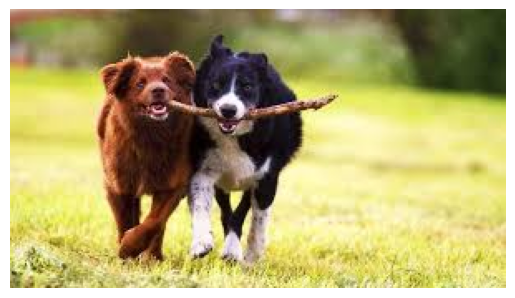

In [21]:
generate_caption2("pic11.jpg")